**Interpret Sign Language with Deep Learning**

*Step 1: Import Modules*

In [1]:
pip install keras scikit-learn pandas numpy matplotlib seaborn opencv-python scikit-image tqdm imbalanced-learn scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Core System and Data Handling
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
from glob import glob
from tqdm import tqdm

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, backend as K
from keras.models import Sequential, Model, model_from_json
from keras.layers import (Dense, Dropout, Activation, Flatten, Conv2D, 
                          MaxPooling2D, Lambda, BatchNormalization, 
                          AveragePooling2D)

# Utilities and Preprocessing
from keras.utils import to_categorical  # Replaces the broken np_utils
from keras.src.legacy.preprocessing.image import ImageDataGenerator # Fixed path
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

# Machine Learning and Scikit-Image
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from skimage.transform import resize
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

*Step 2: Load Data*

In [3]:
import skimage
from tqdm import tqdm
imageSize=50
train_dir = "dataset/asl_alphabet_train/asl_alphabet_train/"
test_dir =  "dataset/asl_alphabet_test/asl_alphabet_test/"
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['A']:
                label = 0
            elif folderName in ['B']:
                label = 1
            elif folderName in ['C']:
                label = 2
            elif folderName in ['D']:
                label = 3
            elif folderName in ['E']:
                label = 4
            elif folderName in ['F']:
                label = 5
            elif folderName in ['G']:
                label = 6
            elif folderName in ['H']:
                label = 7
            elif folderName in ['I']:
                label = 8
            elif folderName in ['J']:
                label = 9
            elif folderName in ['K']:
                label = 10
            elif folderName in ['L']:
                label = 11
            elif folderName in ['M']:
                label = 12
            elif folderName in ['N']:
                label = 13
            elif folderName in ['O']:
                label = 14
            elif folderName in ['P']:
                label = 15
            elif folderName in ['Q']:
                label = 16
            elif folderName in ['R']:
                label = 17
            elif folderName in ['S']:
                label = 18
            elif folderName in ['T']:
                label = 19
            elif folderName in ['U']:
                label = 20
            elif folderName in ['V']:
                label = 21
            elif folderName in ['W']:
                label = 22
            elif folderName in ['X']:
                label = 23
            elif folderName in ['Y']:
                label = 24
            elif folderName in ['Z']:
                label = 25
            elif folderName in ['del']:
                label = 26
            elif folderName in ['nothing']:
                label = 27
            elif folderName in ['space']:
                label = 28           
            else:
                label = 29
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data(train_dir) 
#X_test, y_test= get_data(test_dir) # Too few images
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2) 

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 30)
y_testHot = to_categorical(y_test, num_classes = 30)



100%|██████████| 3000/3000 [00:29<00:00, 102.97it/s]


In [4]:
# Shuffle data to permit further subsampling
from sklearn.utils import shuffle
X_train, y_trainHot = shuffle(X_train, y_trainHot, random_state=13)
X_test, y_testHot = shuffle(X_test, y_testHot, random_state=13)
X_train = X_train[:30000]
X_test = X_test[:30000]
y_trainHot = y_trainHot[:30000]
y_testHot = y_testHot[:30000]

*Step 3: Vizualize Data*

The min/max pixel values are already scaled between 0 and 1

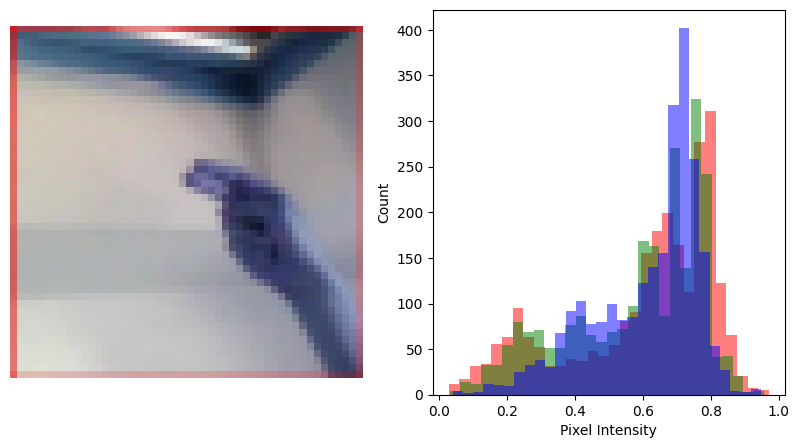

In [5]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

3 images from category "A"

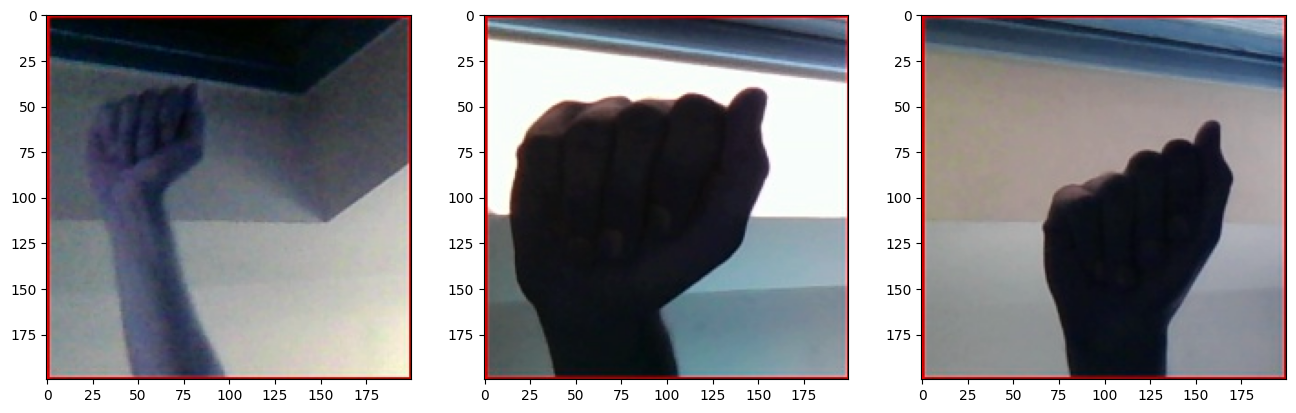

In [6]:
multipleImages = glob('dataset/asl_alphabet_train/asl_alphabet_train/A/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2]))
    #;
plotThreeImages(multipleImages)

3 images from category "B"

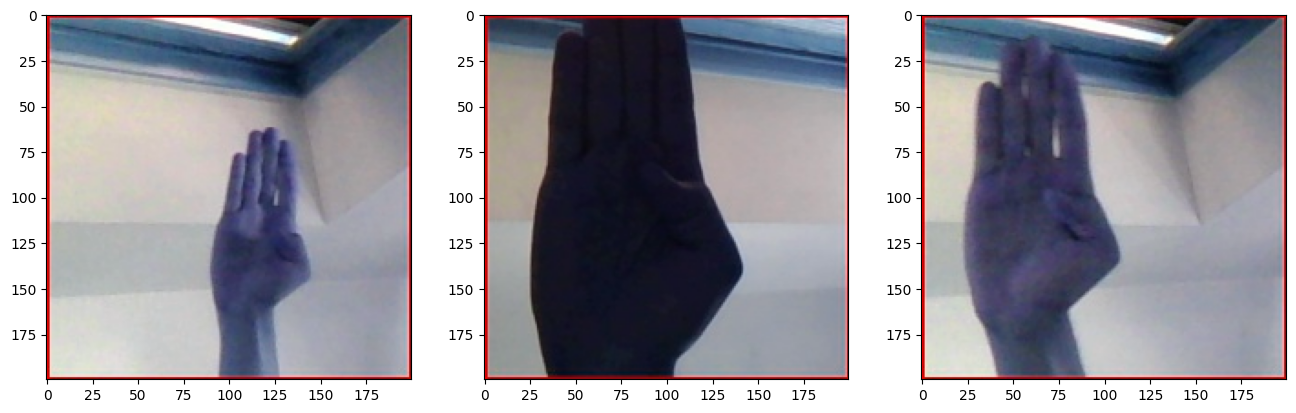

In [7]:
multipleImages = glob('dataset/asl_alphabet_train/asl_alphabet_train/B/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])) 
plotThreeImages(multipleImages)

20 images from category "A"

A


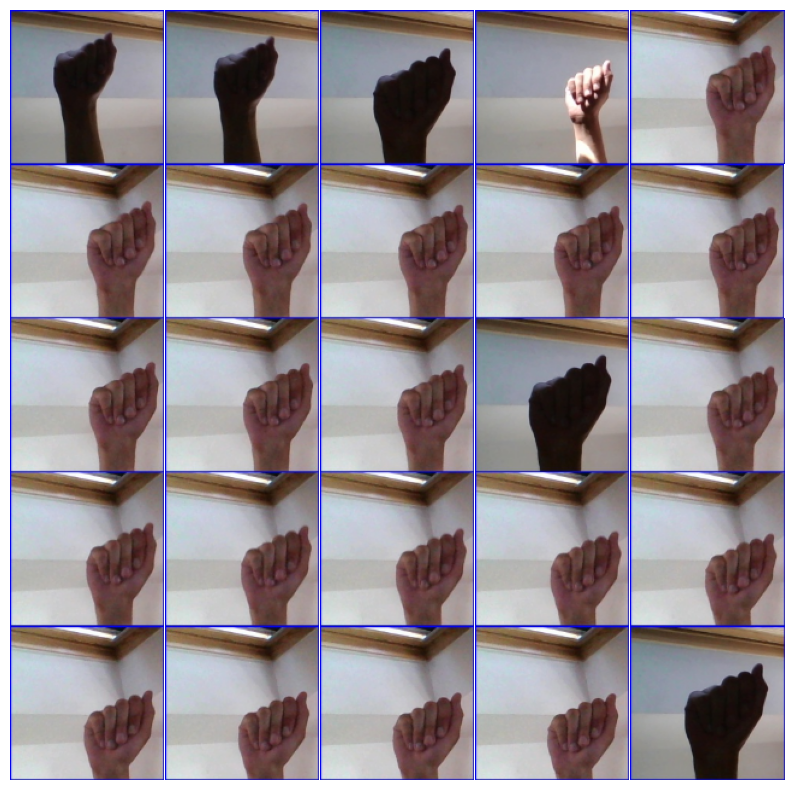

In [8]:
print("A")
multipleImages = glob('dataset/asl_alphabet_train/asl_alphabet_train/A/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

20 images from category "B"

B


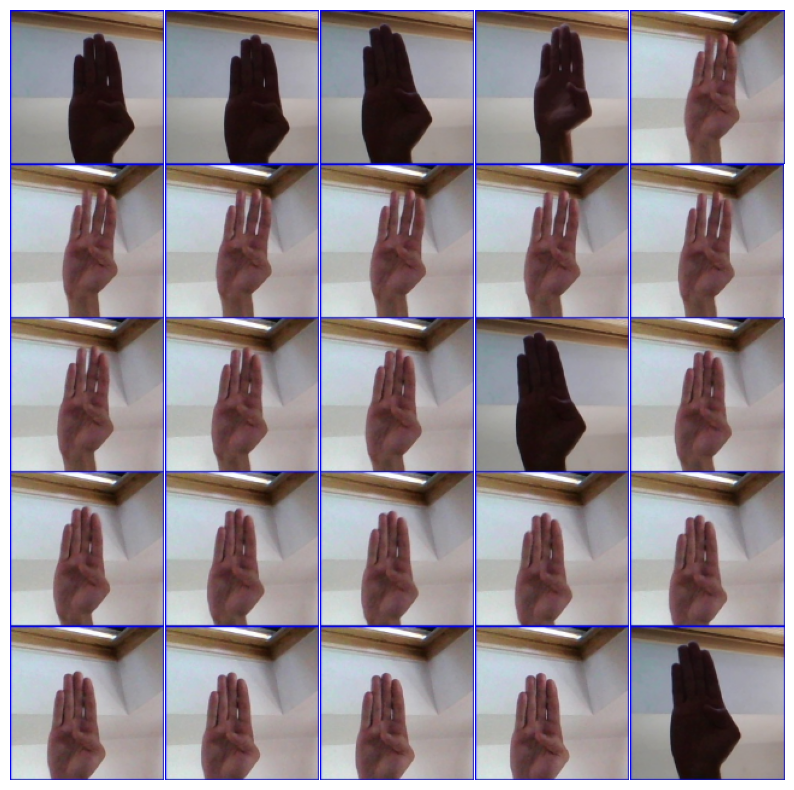

In [9]:
print("B")
multipleImages = glob('dataset/asl_alphabet_train/asl_alphabet_train/B/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

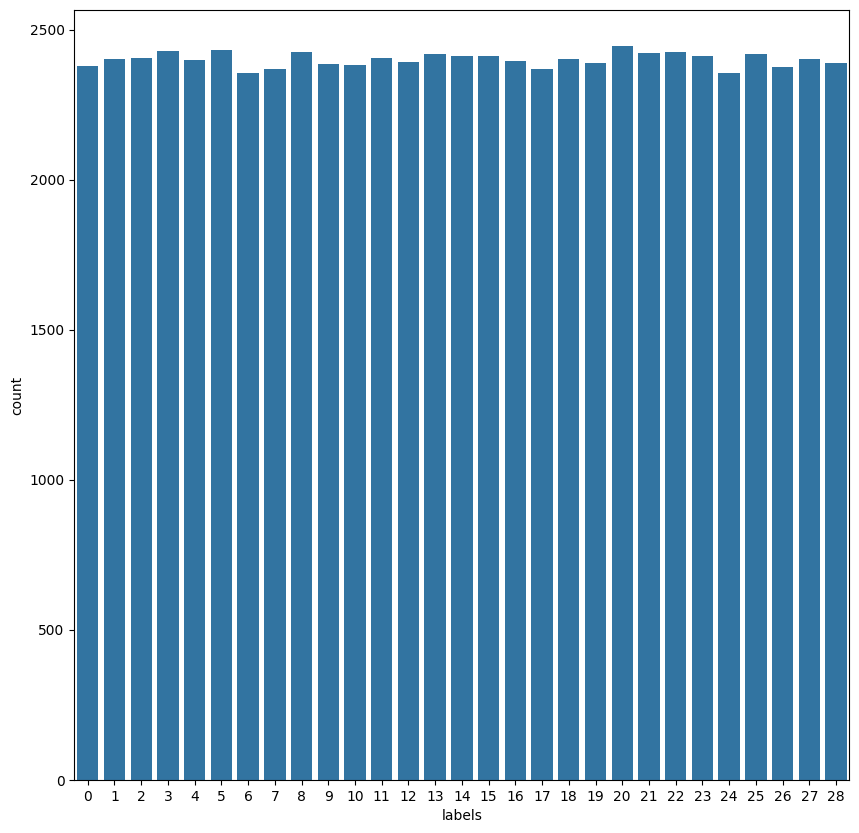

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space', 29: 'other'}


In [10]:
map_characters = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space', 29: 'other'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(x=lab)
plt.show()
print(dict_characters)

*Step 4: Define Helper Functions*

In [11]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['accuracy'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')
    plt.show()

*Step 5: Evaluate Classification Models*

Transfer learning w/ VGG16 Convolutional Network

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 118s 236ms/step - accuracy: 0.5133 - loss: 1.7877 - val_accuracy: 0.7826 - val_loss: 0.9155
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 117s 250ms/step - accuracy: 0.7577 - loss: 0.8384 - val_accuracy: 0.8537 - val_loss: 0.5783
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 120s 255ms/step - accuracy: 0.8261 - loss: 0.5980 - val_accuracy: 0.8993 - val_loss: 0.4081
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 123s 261ms/step - accuracy: 0.8647 - loss: 0.4619 - val_accuracy: 0.9198 - val_loss: 0.3248
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 121s 258ms/step - accuracy: 0.8885 - loss: 0.3794 - val_accuracy: 0.9376 - val_loss: 0.2622
544/544 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step

Classification Report:

              precision    recall  f1-score   support

           A       0.97      0.94      0.95       623
           B       0.96      0.94      0.95       599
           C       0.99      0.98      0.99       595
           D       0.95      0.99      0.97       572
      

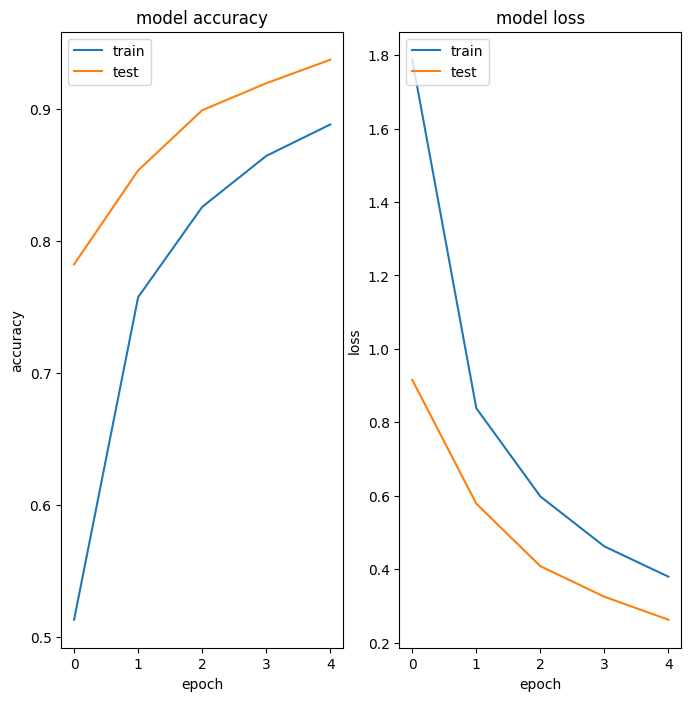

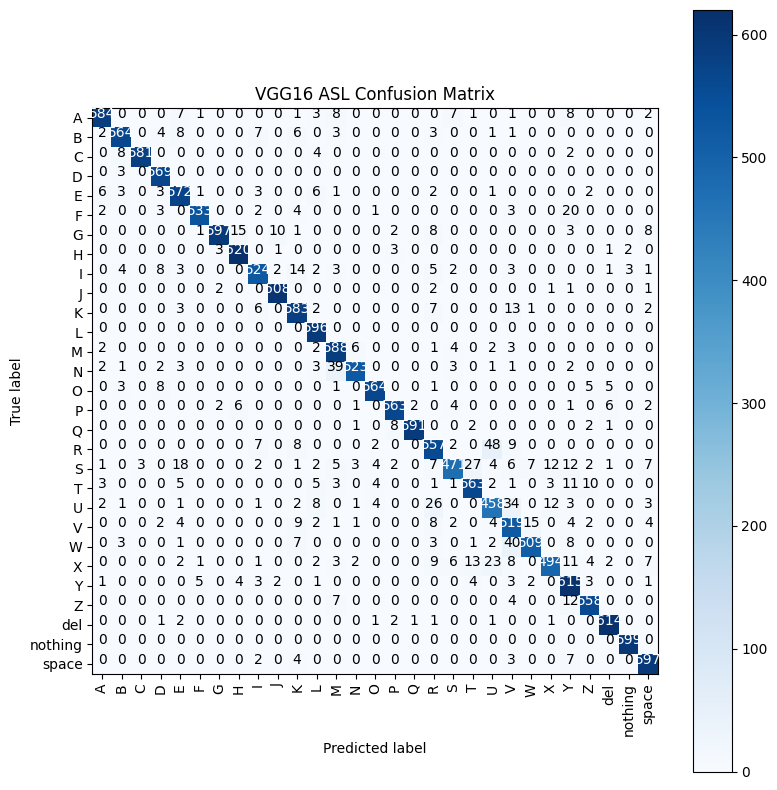

In [13]:
# 1. Build Model: VGG16 Transfer Learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(imageSize, imageSize, 3))
# Freeze pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(30, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 2. Train Model
# Using your X_train and y_trainHot prepared earlier
history = model.fit(
    X_train, y_trainHot, 
    batch_size=64, 
    epochs=5, 
    validation_data=(X_test, y_testHot),
    verbose=1
)
# 3. Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_testHot, axis=1)

# Find unique labels present in the test set to avoid the size mismatch
present_labels = np.unique(np.concatenate((y_true_classes, y_pred_classes)))
target_names = [dict_characters[i] for i in present_labels]

print("\nClassification Report:\n")
# FIX: Added 'labels' parameter to align the names with the numeric data
print(classification_report(y_true_classes, y_pred_classes, labels=present_labels, target_names=target_names))

# Plot Results using your defined functions
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')
    plt.show()

plot_learning_curve(history)
cm = confusion_matrix(y_true_classes, y_pred_classes)
plot_confusion_matrix(cm, classes=target_names, title='VGG16 ASL Confusion Matrix')



In [16]:
# Unfreeze the last 4 layers of the base VGG16 model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile with a much lower learning rate to avoid destroying weights
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Fine-tune for a few more epochs
model.fit(X_train, y_trainHot, epochs=5, validation_data=(X_test, y_testHot))


Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 177s 188ms/step - accuracy: 0.9659 - loss: 0.1080 - val_accuracy: 0.9702 - val_loss: 0.0924
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 184s 196ms/step - accuracy: 0.9813 - loss: 0.0610 - val_accuracy: 0.9773 - val_loss: 0.0757
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 190s 202ms/step - accuracy: 0.9830 - loss: 0.0551 - val_accuracy: 0.9917 - val_loss: 0.0275
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 189s 202ms/step - accuracy: 0.9845 - loss: 0.0514 - val_accuracy: 0.9923 - val_loss: 0.0233
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 184s 196ms/step - accuracy: 0.9894 - loss: 0.0374 - val_accuracy: 0.9944 - val_loss: 0.0177


In [17]:
model.save("asl_mediapipe_mlp_model.h5")

In [18]:
# Evaluate on the test data
scores = model.evaluate(X_test, y_testHot, verbose=0)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

Test Loss: 0.0177
Test Accuracy: 99.44%


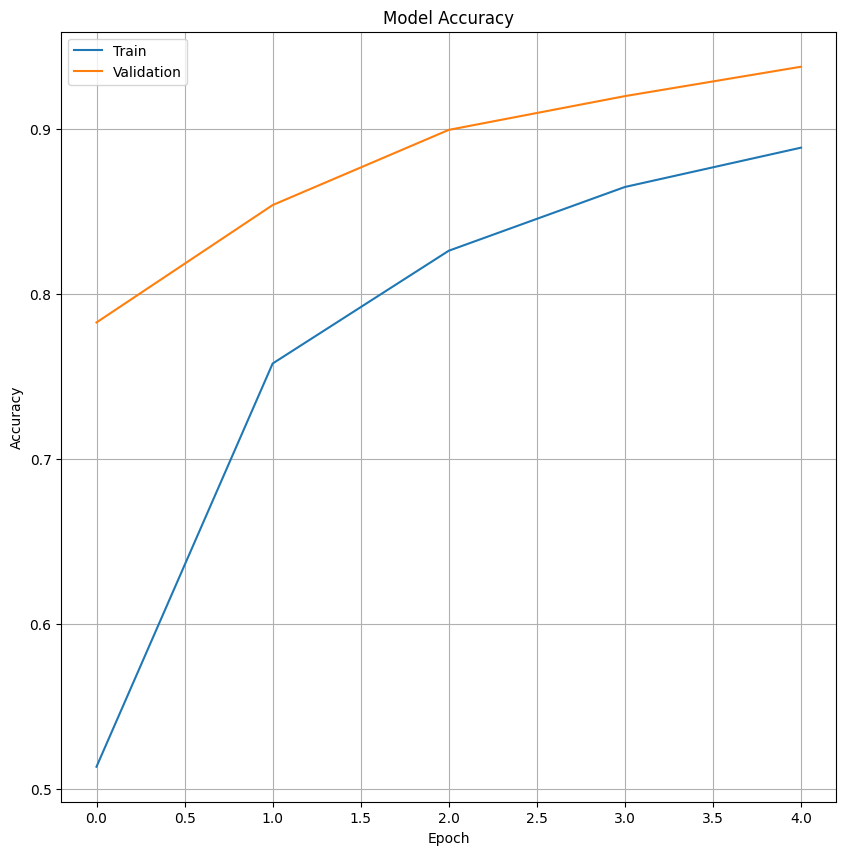

In [19]:
def plot_accuracy_chart(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)
    plt.show()

plot_accuracy_chart(history)

Great, we were able to interpret the signs with an accuracy rate of approximately 92%.